In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

model_number = 3

In [3]:
IN_SHAPE, DELTA = 0, 0
if model_number == 1: 
    IN_SHAPE = 75
    DELTA = config["resolution"]
elif model_number == 2: 
    IN_SHAPE = 64
    DELTA = config["resolution_2"]
else: 
    IN_SHAPE = 64
    DELTA = config["resolution_3"]

MAGNIFICATION = config["magnification"]
N_MAG = config["n_magnification"]
OUT_SHAPE = IN_SHAPE*N_MAG*MAGNIFICATION
LR = 1e-4
EPOCHS = 30

alpha_t_scaling = config["alpha_t_scaling_2"]

alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff_1.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp_1.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

def alpha_delta_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff_2.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp_2.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

def variation_density_loss(alpha):
        diff_x = torch.abs(alpha[:, :, 1:, :] - alpha[:, :, :-1, :])#/((alpha[:, :, 1:, :] + alpha[:, :, :-1, :])/2))
        diff_y = torch.abs(alpha[:, :, :, 1:] - alpha[:, :, :, :-1])#/((alpha[:, :, :, 1:] + alpha[:, :, :, :-1])/2))
        return torch.sum(diff_x)/(diff_x.shape[2]*diff_x.shape[3]) + torch.sum(diff_y)/(diff_y.shape[2]*diff_y.shape[3])

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/

dataset_no_sub = data.LensingDataset('../Simulations/data_model_%d/'%model_number,['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../Simulations/data_model_%d/'%model_number,['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../Simulations/data_model_%d/'%model_number,['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34, 0.66])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34, 0.66])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 5000 (low-resolution) images in total, with a 80:20 validation split. 

In [5]:
dataset_no_sub_test = data.LensingDataset('../Simulations/data_model_%d/'%model_number,['no_sub'],5000)
dataset_axion_test = data.LensingDataset('../Simulations/data_model_%d/'%model_number,['axion'],5000)
dataset_cdm_test = data.LensingDataset('../Simulations/data_model_%d/'%model_number,['cdm'],5000)

In [6]:
classifier = models.Classifier(in_shape=IN_SHAPE, out_classes=3, model=1, in_channels=1, lr=True).to(device)
classifier_criterion = torch.nn.CrossEntropyLoss()
opt_classifier = torch.optim.Adam(params=list(classifier.parameters()),lr=LR)

classifier_params = sum(p.numel() for p in classifier.parameters())
print(f"Classifier network parameters: {classifier_params}")

Classifier network parameters: 277723


In [7]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

classifier.apply(init_weights)

Classifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (b1): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (b2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv3): Conv2d(16, 24, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (b3): Sequential(
    (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv4): Conv2d(24, 32, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (b4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), 

In [8]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
best_delta_weights = None
history = {'c_loss':[], 'c_val_loss':[], 'accs':[], 'val_accs':[]} # tracks the train and val losses and training results at each epoch
for epoch in range(EPOCHS):
    classifier_losses = []
    accs = []
    classifier.train()
    for i,(x, label) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x, label) = (x.float().to(device), label.to(device))
        class_prediction = classifier(x)
        classifier_loss = classifier_criterion(class_prediction, label)
        opt_classifier.zero_grad()
        classifier_loss.backward()
        opt_classifier.step()
        classifier_losses.append(float(classifier_loss))
        prediction_indices = torch.argmax(class_prediction, 1)
        acc = float(torch.sum(label == prediction_indices))/float(len(label))
        accs.append(float(acc))
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(classifier_losses)} and acc {np.mean(accs)} at LR={opt_classifier.param_groups[0]['lr']}")
    history['c_loss'].append(np.mean(classifier_losses))
    history['accs'].append(np.mean(accs))

    classifier.eval()
    classifier_losses = []
    accs = []
    for i,(x, label) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x, label) = (x.float().to(device), label.to(device))
        class_prediction = classifier(x)
        classifier_loss = classifier_criterion(class_prediction, label)
        classifier_losses.append(float(classifier_loss))
        prediction_indices = torch.argmax(class_prediction, 1)
        acc = float(torch.sum(label == prediction_indices))/float(len(label))
        accs.append(float(acc))
    if best_val_loss > np.mean(classifier_losses):
        best_val_loss = np.mean(classifier_losses)
        best_weights = classifier.state_dict()
    history['c_val_loss'].append(np.mean(classifier_losses))
    history['val_accs'].append(np.mean(accs))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(classifier_losses)} and acc {np.mean(accs)} at LR={opt_classifier.param_groups[0]['lr']}")

Training epoch 1: 100%|██████████| 816/816 [00:04<00:00, 180.56it/s]


Training at epoch 1/30: 1.0516213663652831 and acc 0.4348039215686275 at LR=0.0001


Validation epoch 1: 100%|██████████| 204/204 [00:00<00:00, 222.21it/s]


Validation at epoch 1/30: 1.0075311301385654 and acc 0.46470588235294125 at LR=0.0001


Training epoch 2: 100%|██████████| 816/816 [00:04<00:00, 191.43it/s]


Training at epoch 2/30: 0.8103582508880279 and acc 0.6232843137254902 at LR=0.0001


Validation epoch 2: 100%|██████████| 204/204 [00:00<00:00, 244.51it/s]


Validation at epoch 2/30: 0.943466525232675 and acc 0.6049019607843138 at LR=0.0001


Training epoch 3: 100%|██████████| 816/816 [00:04<00:00, 189.50it/s]


Training at epoch 3/30: 0.6386432911397195 and acc 0.7166666666666666 at LR=0.0001


Validation epoch 3: 100%|██████████| 204/204 [00:00<00:00, 229.19it/s]


Validation at epoch 3/30: 0.6110067417224249 and acc 0.7303921568627451 at LR=0.0001


Training epoch 4: 100%|██████████| 816/816 [00:04<00:00, 185.84it/s]


Training at epoch 4/30: 0.5658631635756761 and acc 0.7524509803921569 at LR=0.0001


Validation epoch 4: 100%|██████████| 204/204 [00:00<00:00, 233.12it/s]


Validation at epoch 4/30: 0.5697918459773064 and acc 0.7450980392156863 at LR=0.0001


Training epoch 5: 100%|██████████| 816/816 [00:04<00:00, 192.86it/s]


Training at epoch 5/30: 0.5175725654014113 and acc 0.780392156862745 at LR=0.0001


Validation epoch 5: 100%|██████████| 204/204 [00:00<00:00, 247.15it/s]


Validation at epoch 5/30: 0.47673488397370367 and acc 0.803921568627451 at LR=0.0001


Training epoch 6: 100%|██████████| 816/816 [00:04<00:00, 198.65it/s]


Training at epoch 6/30: 0.4869556905674365 and acc 0.7960784313725491 at LR=0.0001


Validation epoch 6: 100%|██████████| 204/204 [00:00<00:00, 234.09it/s]


Validation at epoch 6/30: 0.6025857291567851 and acc 0.7039215686274508 at LR=0.0001


Training epoch 7: 100%|██████████| 816/816 [00:04<00:00, 188.82it/s]


Training at epoch 7/30: 0.4632276579208088 and acc 0.8007352941176472 at LR=0.0001


Validation epoch 7: 100%|██████████| 204/204 [00:00<00:00, 216.80it/s]


Validation at epoch 7/30: 0.4319771944234769 and acc 0.8235294117647058 at LR=0.0001


Training epoch 8: 100%|██████████| 816/816 [00:04<00:00, 179.56it/s]


Training at epoch 8/30: 0.44202880305922865 and acc 0.8147058823529412 at LR=0.0001


Validation epoch 8: 100%|██████████| 204/204 [00:00<00:00, 210.41it/s]


Validation at epoch 8/30: 0.4175903470273696 and acc 0.8205882352941175 at LR=0.0001


Training epoch 9: 100%|██████████| 816/816 [00:04<00:00, 173.68it/s]


Training at epoch 9/30: 0.4293179576486057 and acc 0.8164215686274511 at LR=0.0001


Validation epoch 9: 100%|██████████| 204/204 [00:00<00:00, 257.93it/s]


Validation at epoch 9/30: 0.4104238022118807 and acc 0.8352941176470589 at LR=0.0001


Training epoch 10: 100%|██████████| 816/816 [00:04<00:00, 196.02it/s]


Training at epoch 10/30: 0.40914217147556153 and acc 0.8276960784313726 at LR=0.0001


Validation epoch 10: 100%|██████████| 204/204 [00:00<00:00, 233.85it/s]


Validation at epoch 10/30: 0.4736095940073331 and acc 0.8235294117647058 at LR=0.0001


Training epoch 11: 100%|██████████| 816/816 [00:04<00:00, 187.08it/s]


Training at epoch 11/30: 0.39275460770609333 and acc 0.8370098039215687 at LR=0.0001


Validation epoch 11: 100%|██████████| 204/204 [00:00<00:00, 220.07it/s]


Validation at epoch 11/30: 0.3680762085771444 and acc 0.8568627450980392 at LR=0.0001


Training epoch 12: 100%|██████████| 816/816 [00:04<00:00, 184.93it/s]


Training at epoch 12/30: 0.38583354973439676 and acc 0.8419117647058824 at LR=0.0001


Validation epoch 12: 100%|██████████| 204/204 [00:00<00:00, 235.32it/s]


Validation at epoch 12/30: 0.3777994258767542 and acc 0.8696078431372548 at LR=0.0001


Training epoch 13: 100%|██████████| 816/816 [00:04<00:00, 186.11it/s]


Training at epoch 13/30: 0.3855020162186074 and acc 0.8424019607843138 at LR=0.0001


Validation epoch 13: 100%|██████████| 204/204 [00:00<00:00, 226.72it/s]


Validation at epoch 13/30: 0.42800598102165205 and acc 0.8176470588235295 at LR=0.0001


Training epoch 14: 100%|██████████| 816/816 [00:04<00:00, 171.87it/s]


Training at epoch 14/30: 0.3694798729037775 and acc 0.8419117647058824 at LR=0.0001


Validation epoch 14: 100%|██████████| 204/204 [00:00<00:00, 215.76it/s]


Validation at epoch 14/30: 0.3984631926606537 and acc 0.8333333333333334 at LR=0.0001


Training epoch 15: 100%|██████████| 816/816 [00:04<00:00, 168.85it/s]


Training at epoch 15/30: 0.3655358128570358 and acc 0.8438725490196078 at LR=0.0001


Validation epoch 15: 100%|██████████| 204/204 [00:00<00:00, 231.32it/s]


Validation at epoch 15/30: 0.35570748726946905 and acc 0.8578431372549019 at LR=0.0001


Training epoch 16: 100%|██████████| 816/816 [00:03<00:00, 208.36it/s]


Training at epoch 16/30: 0.35202149166976665 and acc 0.8573529411764707 at LR=0.0001


Validation epoch 16: 100%|██████████| 204/204 [00:00<00:00, 236.61it/s]


Validation at epoch 16/30: 0.3763110396616599 and acc 0.8480392156862745 at LR=0.0001


Training epoch 17: 100%|██████████| 816/816 [00:04<00:00, 193.30it/s]


Training at epoch 17/30: 0.3464098388452412 and acc 0.8534313725490196 at LR=0.0001


Validation epoch 17: 100%|██████████| 204/204 [00:00<00:00, 255.29it/s]


Validation at epoch 17/30: 0.38043592210092086 and acc 0.85 at LR=0.0001


Training epoch 18: 100%|██████████| 816/816 [00:03<00:00, 210.11it/s]


Training at epoch 18/30: 0.3502472312076647 and acc 0.8495098039215687 at LR=0.0001


Validation epoch 18: 100%|██████████| 204/204 [00:00<00:00, 253.07it/s]


Validation at epoch 18/30: 0.46369083933806154 and acc 0.8235294117647058 at LR=0.0001


Training epoch 19: 100%|██████████| 816/816 [00:04<00:00, 198.49it/s]


Training at epoch 19/30: 0.327885432174548 and acc 0.8637254901960784 at LR=0.0001


Validation epoch 19: 100%|██████████| 204/204 [00:00<00:00, 245.96it/s]


Validation at epoch 19/30: 0.6138034887456646 and acc 0.7127450980392156 at LR=0.0001


Training epoch 20: 100%|██████████| 816/816 [00:04<00:00, 193.14it/s]


Training at epoch 20/30: 0.3275717556927132 and acc 0.8612745098039215 at LR=0.0001


Validation epoch 20: 100%|██████████| 204/204 [00:00<00:00, 240.74it/s]


Validation at epoch 20/30: 0.4676828340937694 and acc 0.8078431372549019 at LR=0.0001


Training epoch 21: 100%|██████████| 816/816 [00:04<00:00, 190.88it/s]


Training at epoch 21/30: 0.316445806119066 and acc 0.8659313725490196 at LR=0.0001


Validation epoch 21: 100%|██████████| 204/204 [00:00<00:00, 249.82it/s]


Validation at epoch 21/30: 0.4076425369507085 and acc 0.8362745098039216 at LR=0.0001


Training epoch 22: 100%|██████████| 816/816 [00:03<00:00, 206.26it/s]


Training at epoch 22/30: 0.31190867003797573 and acc 0.8700980392156863 at LR=0.0001


Validation epoch 22: 100%|██████████| 204/204 [00:00<00:00, 225.31it/s]


Validation at epoch 22/30: 0.35230129774586827 and acc 0.8588235294117648 at LR=0.0001


Training epoch 23: 100%|██████████| 816/816 [00:04<00:00, 189.13it/s]


Training at epoch 23/30: 0.31907697883206326 and acc 0.8688725490196079 at LR=0.0001


Validation epoch 23: 100%|██████████| 204/204 [00:00<00:00, 239.93it/s]


Validation at epoch 23/30: 0.3539949066368589 and acc 0.8529411764705882 at LR=0.0001


Training epoch 24: 100%|██████████| 816/816 [00:04<00:00, 185.31it/s]


Training at epoch 24/30: 0.3015197555337092 and acc 0.8786764705882353 at LR=0.0001


Validation epoch 24: 100%|██████████| 204/204 [00:00<00:00, 234.30it/s]


Validation at epoch 24/30: 0.3689787279284906 and acc 0.8470588235294116 at LR=0.0001


Training epoch 25: 100%|██████████| 816/816 [00:04<00:00, 184.73it/s]


Training at epoch 25/30: 0.3007918842832784 and acc 0.8811274509803921 at LR=0.0001


Validation epoch 25: 100%|██████████| 204/204 [00:00<00:00, 224.18it/s]


Validation at epoch 25/30: 0.3600143841193879 and acc 0.8598039215686274 at LR=0.0001


Training epoch 26: 100%|██████████| 816/816 [00:04<00:00, 181.47it/s]


Training at epoch 26/30: 0.2986553567276204 and acc 0.8713235294117647 at LR=0.0001


Validation epoch 26: 100%|██████████| 204/204 [00:00<00:00, 215.16it/s]


Validation at epoch 26/30: 0.35943215425290603 and acc 0.8450980392156862 at LR=0.0001


Training epoch 27: 100%|██████████| 816/816 [00:04<00:00, 201.26it/s]


Training at epoch 27/30: 0.28635947468694 and acc 0.8830882352941177 at LR=0.0001


Validation epoch 27: 100%|██████████| 204/204 [00:00<00:00, 247.82it/s]


Validation at epoch 27/30: 0.30757968289339366 and acc 0.8715686274509804 at LR=0.0001


Training epoch 28: 100%|██████████| 816/816 [00:04<00:00, 203.29it/s]


Training at epoch 28/30: 0.27625115318440685 and acc 0.8830882352941177 at LR=0.0001


Validation epoch 28: 100%|██████████| 204/204 [00:00<00:00, 244.53it/s]


Validation at epoch 28/30: 0.4697022056172821 and acc 0.8088235294117647 at LR=0.0001


Training epoch 29: 100%|██████████| 816/816 [00:04<00:00, 201.49it/s]


Training at epoch 29/30: 0.29056065420730853 and acc 0.8772058823529413 at LR=0.0001


Validation epoch 29: 100%|██████████| 204/204 [00:00<00:00, 244.98it/s]


Validation at epoch 29/30: 0.39682318125486227 and acc 0.8294117647058823 at LR=0.0001


Training epoch 30: 100%|██████████| 816/816 [00:04<00:00, 185.64it/s]


Training at epoch 30/30: 0.27044511053884657 and acc 0.8865196078431372 at LR=0.0001


Validation epoch 30: 100%|██████████| 204/204 [00:00<00:00, 234.37it/s]

Validation at epoch 30/30: 0.35822143836754977 and acc 0.8735294117647058 at LR=0.0001


In [9]:
classifier.load_state_dict(best_weights)

<All keys matched successfully>

In [10]:
history_no_sub = {'no_sub':0,'axion':0, 'cdm':0}
history_axion = {'no_sub':0,'axion':0, 'cdm':0}
history_cdm = {'no_sub':0,'axion':0, 'cdm':0}
preds, probs, ys = [], [], []
worst_case = 0
best_case = 0
mid_case = 0
extra = 0

classifier.eval()
for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating CDM sub-structure images"):
    x, label = dataset_no_sub_test[i]
    class_prediction = classifier(x.float().unsqueeze(0).to(device))
    pred = torch.argmax(class_prediction, 1)
    probabilities = torch.softmax(class_prediction, dim=1)
    ys = ys + [label]
    preds = preds + list(pred.detach().cpu().numpy())
    probs = probs + list(probabilities.detach().cpu().numpy())
    if pred == 0:
        history_no_sub['no_sub'] += 1
    elif pred == 1:
        history_no_sub['axion'] += 1
    elif pred == 2:
        history_no_sub['cdm'] += 1

for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating no sub-structure images"):
    x, label = dataset_axion_test[i]
    class_prediction = classifier(x.float().unsqueeze(0).to(device))
    pred = torch.argmax(class_prediction, 1)
    probabilities = torch.softmax(class_prediction, dim=1)
    ys = ys + [label]
    preds = preds + list(pred.detach().cpu().numpy())
    probs = probs + list(probabilities.detach().cpu().numpy())
    if pred == 0:
        history_axion['no_sub'] += 1
    elif pred == 1:
        history_axion['axion'] += 1
    elif pred == 2:
        history_axion['cdm'] += 1

for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating axion DM sub-structure images"):
    x, label = dataset_cdm_test[i]
    class_prediction = classifier(x.float().unsqueeze(0).to(device))
    pred = torch.argmax(class_prediction, 1)
    probabilities = torch.softmax(class_prediction, dim=1)
    ys = ys + [label]
    preds = preds + list(pred.detach().cpu().numpy())
    probs = probs + list(probabilities.detach().cpu().numpy())
    if pred == 0:
        history_cdm['no_sub'] += 1
    elif pred == 1:
        history_cdm['axion'] += 1
    elif pred == 2:
        history_cdm['cdm'] += 1

Evaluating axion DM sub-structure images: 100%|██████████| 5000/5000 [00:07<00:00, 693.16it/s]


In [11]:
from prettytable import PrettyTable

pt = PrettyTable(['', 'no_sub', 'axion', 'cdm'])
pt.add_row(['no_sub',history_no_sub['no_sub'],history_no_sub['axion'],history_no_sub['cdm']])
pt.add_row(['axion',history_axion['no_sub'],history_axion['axion'],history_axion['cdm']])
pt.add_row(['cdm',history_cdm['no_sub'],history_cdm['axion'],history_cdm['cdm']])
print(pt)

+--------+--------+-------+------+
|        | no_sub | axion | cdm  |
+--------+--------+-------+------+
| no_sub |  4969  |   0   |  31  |
| axion  |   24   |  4067 | 909  |
|  cdm   |  732   |  308  | 3960 |
+--------+--------+-------+------+


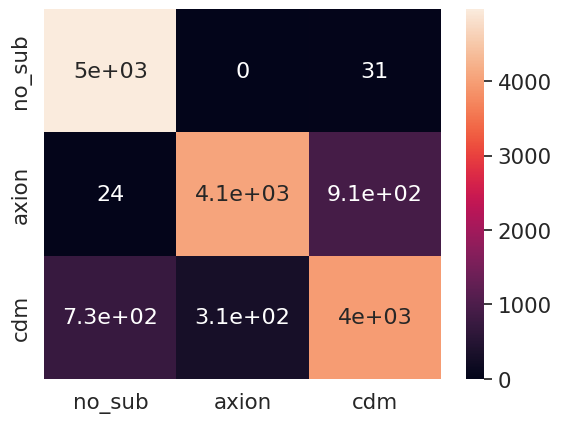

In [12]:
import pandas as pd
import seaborn as sn
conf_mat = [[history_no_sub['no_sub'],history_no_sub['axion'],history_no_sub['cdm']],
            [history_axion['no_sub'],history_axion['axion'],history_axion['cdm']],
            [history_cdm['no_sub'],history_cdm['axion'],history_cdm['cdm']]]
df_cm = pd.DataFrame(conf_mat, ['no_sub','axion','cdm'], ['no_sub','axion','cdm'])

# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [13]:
for i in range(len(ys)):
    if probs[i][ys[i]] == np.min(probs[i]): worst_case += 1
    elif ys[i] == preds[i]: best_case += 1
    elif probs[i][ys[i]] == sorted(probs[i])[1]: mid_case += 1
    else: extra += 1

In [14]:
"""
Model 2:
+--------+--------+-------+------+
|        | no_sub | axion | cdm  |
+--------+--------+-------+------+
| no_sub |  4789  |   0   | 211  |
| axion  |   6    |  4103 | 891  |
|  cdm   |  636   |  454  | 3910 |
+--------+--------+-------+------+

Model 3:
+--------+--------+-------+------+
|        | no_sub | axion | cdm  |
+--------+--------+-------+------+
| no_sub |  4942  |   0   |  58  |
| axion  |   2    |  4487 | 511  |
|  cdm   |  299   |  216  | 4485 |
+--------+--------+-------+------+
"""

'\nModel 2:\n+--------+--------+-------+------+\n|        | no_sub | axion | cdm  |\n+--------+--------+-------+------+\n| no_sub |  4789  |   0   | 211  |\n| axion  |   6    |  4103 | 891  |\n|  cdm   |  636   |  454  | 3910 |\n+--------+--------+-------+------+\n\nModel 3:\n+--------+--------+-------+------+\n|        | no_sub | axion | cdm  |\n+--------+--------+-------+------+\n| no_sub |  4942  |   0   |  58  |\n| axion  |   2    |  4487 | 511  |\n|  cdm   |  299   |  216  | 4485 |\n+--------+--------+-------+------+\n'

In [15]:
ns_curves = []
lr_curves = []
aucs = []
for i in range(3):
    y_ = []
    probs_ = []
    for j in range(len(preds)):
        if i==ys[j] and ys[j]==preds[j]:
            y_.append(1)
        else: y_.append(0)
        probs_.append(probs[j][i])
    ns_probs = np.array([1/len(probs_) for __ in range(len(probs_))])
    ns_auc = roc_auc_score(y_, ns_probs,multi_class='ovr')
    lr_auc = roc_auc_score(y_, probs_,multi_class='ovr')
    aucs.append((ns_auc,lr_auc))

    ns_fpr, ns_tpr, _ = roc_curve(y_, np.array([0 for i in range(len(y_))]))
    lr_fpr, lr_tpr, _ = roc_curve(y_, probs_)
    ns_curves.append((ns_fpr, ns_tpr))
    lr_curves.append((lr_fpr, lr_tpr))

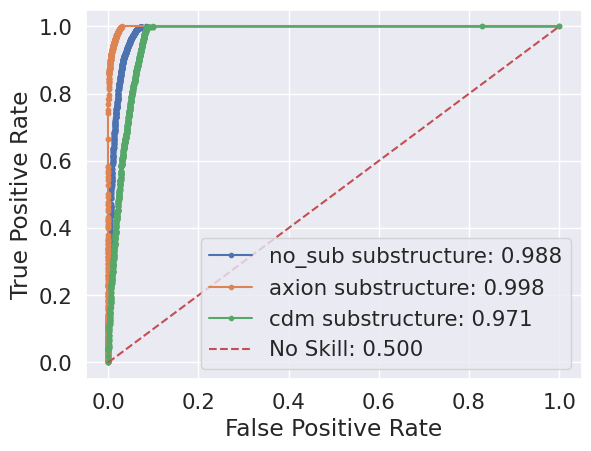

Correct identifications: 0.8664
True had least prob: 0.0074
True had 2nd highest prob: 0.1262
Sum for verification = 1.0


In [16]:
classes = ['no_sub','axion','cdm']
for i in range(3):
    plt.plot(lr_curves[i][0], lr_curves[i][1], marker='.', label='%s substructure: %.3f'%(classes[i],aucs[i][1]))
plt.plot(ns_curves[0][0], ns_curves[0][1], linestyle='--', label='No Skill: %.3f'%(aucs[0][0]))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
print("Correct identifications: %s\nTrue had least prob: %s\nTrue had 2nd highest prob: %s\nSum for verification = %s"%(best_case/len(ys),worst_case/len(ys),mid_case/len(ys),(best_case+worst_case+mid_case)/len(ys)))